# Evolutionary parameter search with a single neural mass model
This notebook provides a simple example for the use of the evolutionary optimization framework built-in to the library. Under the hood, the implementation of the evolutionary algorithm is powered by `deap` and `pypet` cares about the parallelization and storage of the simulation data for us.

We want to optimize for a simple target, namely finding a parameter configuration that produces activity with a peak power frequency spectrum at 25 Hz.

In this notebook, we will also plot the evolutionary genealogy tree, to visualize how the population evolves over generations.

In [ ]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [ ]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib seaborn
    import matplotlib.pyplot as plt
    
import numpy as np
import logging 

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution
import neurolib.utils.functions as func

import neurolib.optimize.evolution.deapUtils as deapUtils

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

## Model definition

In [3]:
aln = ALNModel()

In [5]:
# Here we define our evaluation function. This function will
# be called reapedly and perform a single simulation. The object
# that is passed to the function, `traj`, is a pypet trajectory
# and serves as a "bridge" to load the parameter set of this 
# particular trajectory and execute a run.
# Then the power spectrum of the run is computed and its maximum
# is fitted to the target of 25 Hz peak frequency.
def evaluateSimulation(traj):
    # The trajectory id is provided as an attribute
    rid = traj.id
    logging.info("Running run id {}".format(rid))
    # this function provides the a model with the partuclar
    # parameter set for this given run
    model = evolution.getModelFromTraj(traj)
    # parameters can also be modified after loading
    model.params['dt'] = 0.1
    model.params['duration'] = 2*1000.
    # and the simulation is run
    model.run()
    
    # compute power spectrum
    frs, powers = func.getPowerSpectrum(model.rates_exc[:, -int(1000/model.params['dt']):], dt=model.params['dt'])
    # find the peak frequency
    domfr = frs[np.argmax(powers)] 
    # fitness evaluation: let's try to find a 25 Hz oscillation
    fitness = abs(domfr - 25) 
    # deap needs a fitness *tuple*!
    fitness_tuple = ()
    # more fitness values could be added
    fitness_tuple += (fitness, )
    # we need to return the fitness tuple and the outputs of the model
    return fitness_tuple, model.outputs

## Initialize and run evolution

The evolutionary algorithm tries to find the optimal parameter set that will maximize (or minimize) a certain fitness function. 

This achieved by seeding an initial population of size `POP_INIT_SIZE` that is randomly initiated in the parameter space `parameterSpace`. INIT: After simulating the initial population using `evalFunction`, only a subset of the individuals is kept, defined by `POP_SIZE`. 

START: Members of the remaining population are chosen based on their fitness (using rank selection) to mate and produce `offspring`. These `offspring` have parameters that are drawn from a normal distribution defined by the mean of the parameters between the two parents. Then the `offspring` population is evaluated and the process loops back to START: 

This process is repeated for `NGEN` generations.

In [ ]:
# Here we define the parameters and the range in which we want
# to perform the evolutionary optimization.
# Create a `ParameterSpace` 
pars = ParameterSpace(['mue_ext_mean', 'mui_ext_mean'], [[0.0, 4.0], [0.0, 4.0]])
# Iitialize evolution with
# :evaluateSimulation: The function that returns a fitness, 
# :pars: The parameter space and its boundaries to optimize
# :model: The model that should be passed to the evaluation function
# :weightList: A list of optimization weights for the `fitness_tuple`,
#              positive values will lead to a maximization, negative 
#              values to a minimzation. The length of this list must
#              be the same as the length of the `fitness_tuple`.
# 
# :POP_INIT_SIZE: The size of the initial population that will be 
#              randomly sampled in the parameter space `pars`.
#              Should be higher than POP_SIZE. 50-200 might be a good
#              range to start experimenting with.
# :POP_SIZE: Size of the population that should evolve. Must be an
#              even number. 20-100 might be a good range to start with.
# :NGEN: Number of generations to simulate the evolution for. A good
#              range to start with might be 20-100.

weightList = [-1.0]

evolution = Evolution(evalFunction = evaluateSimulation, parameterSpace = pars, model = aln, weightList = [-1.0],
                      POP_INIT_SIZE=4, POP_SIZE = 4, NGEN=2, filename="example-2.1.hdf")
# info: chose POP_INIT_SIZE=50, POP_SIZE = 20, NGEN=20 for real exploration, 
# values are lower here for testing

In [ ]:
# Enabling `verbose = True` will print statistics and generate plots 
# of the current population for each generation.
evolution.run(verbose = False)

# Analysis

### Population

In [8]:
# the current population is always accesible via
pop = evolution.pop
# we can also use the functions registered to deap
# to select the best of the population:
best_10 = evolution.toolbox.selBest(pop, k=10)
# Remember, we performed a minimization so a fitness
# of 0 is optimal
print("Best individual", best_10[0], "fitness", best_10[0].fitness)

Best individual [0.9246584781690865, 0.07518939226515182, 0.7244430240896134, 0.42936681736868265] fitness (0.0,)


> Simulation parameters
HDF file storage: ./data/hdf/example-2.1.hdf
Trajectory Name: results-2020-05-19-19H-15M-08S
Duration of evaluating initial population 0:00:30.890716
Duration of evolution 0:04:32.291688
Model: <class 'neurolib.models.aln.model.ALNModel'>
Model name: aln
Eval function: <function evaluateSimulation at 0x10c28f510>
Parameter space: ParameterSpace(mue_ext_mean=[0.0, 4.0], mui_ext_mean=[0.0, 4.0])
> Evolution parameters
Number of generations: 20
Initial population size: 50
Population size: 20
> Evolutionary operators
Mating operator: <function cxBlend at 0x11e3b1b70>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x11fce2d90>
Selection paramter: {}
Parent selection operator: <function selRank at 0x11fce2d08>
Comments: no comments
--- Info summary ---
Valid: 20
Mean score (weighted fitness): -0.35
Parameter distribution (Generation 19):
mue_ext_mean: 	 mean: 1.058,	 std: 0.09356
mui_ext_mean: 	 mean: 0.2097,	 std: 0.06772
----------

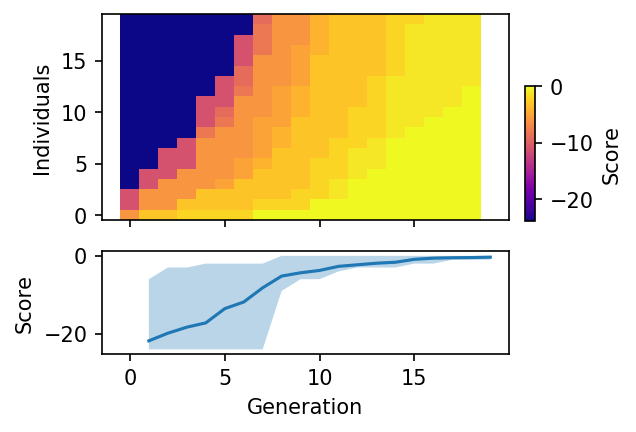

MainProcess root INFO     Saving plot to ./data/figures/results-2020-05-19-19H-15M-08S_hist_19.png


There are 20 valid individuals
Mean score across population: -0.35


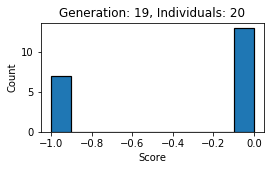

<Figure size 432x288 with 0 Axes>

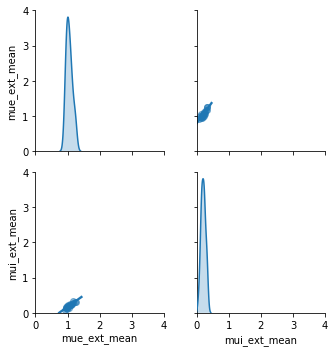

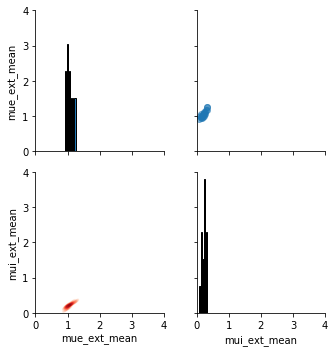

In [10]:
# a sinple overview of the current population (in this case the 
# last one) is given via the `info()` method. This provides a 
# a histogram of the score (= mean fitness) and scatterplots
# and density estimates across orthogonal parameter space cross 
# sections.
evolution.info(plot=True)

# Plotting genealogy tree

`neurolib` keeps track of all individuals during the evolution. You can see all individuals from each generation by calling `evolution.history`. The object `evolution.tree` provides a network description of the genealogy of the evolution: each individual (indexed by its unique `.id`) is connected to its parents. We can use this object in combination with the network library `networkx` to plot the tree:

/Users/caglar/anaconda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/caglar/anaconda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


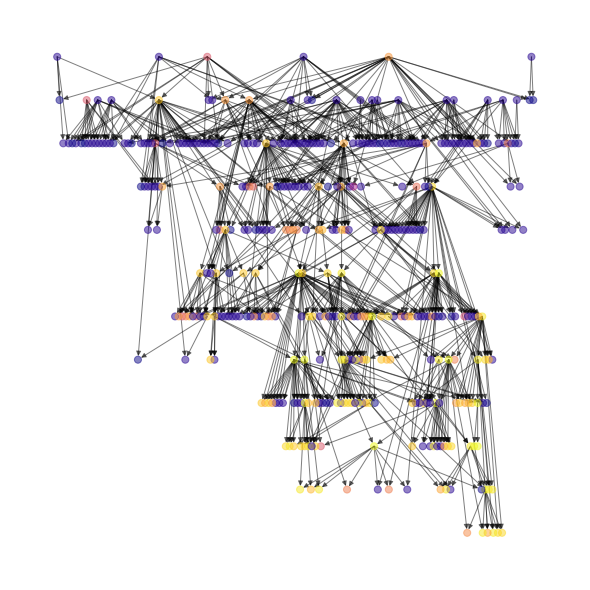

In [12]:
# we put this into a try except block since we don't do testing on networkx
try:
    import matplotlib.pyplot as plt
    import networkx as nx
    from networkx.drawing.nx_pydot import graphviz_layout

    G = nx.DiGraph(evolution.tree)
    G = G.reverse()     # Make the graph top-down
    pos = graphviz_layout(G, prog='dot')
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_size=50, alpha=0.5, node_color=list(evolution.id_score.values()), with_labels=False)
    plt.show()
except:
    print("It looks like networkx or pydot are not installed")